In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Optionally, set the font for other elements (titles, labels, etc.)
mpl.rcParams['axes.titleweight'] = 'normal'
mpl.rcParams['axes.labelweight'] = 'normal'

# Apply scaling to all axis labels, titles, and ticks globally
factor = 1/0.8  # Adjust this factor as needed
base_fontsize_title = 16
base_fontsize_labels = 14
base_fontsize_ticks = 12  # Add a base fontsize for ticks

# Set the font size for titles, labels, and ticks globally
mpl.rcParams['axes.titlesize'] = base_fontsize_title * factor
mpl.rcParams['axes.labelsize'] = base_fontsize_labels * factor
mpl.rcParams['xtick.labelsize'] = base_fontsize_ticks * factor
mpl.rcParams['ytick.labelsize'] = base_fontsize_ticks * factor
np.loadtxt("51Peg_mayorqueloz95.csv", delimiter=",", skiprows=1)

array([[  2.80873, -46.96   ,   3.6    ],
       [  2.95979, -47.39   ,   4.5    ],
       [  3.62695, -19.85   ,   2.9    ],
       [  3.73265, -13.47   ,   2.6    ],
       [  3.90077,  -5.782  ,   3.     ],
       [  4.60753,  49.41   ,   2.2    ],
       [  4.78429,  58.66   ,   2.5    ],
       [  4.90699,  63.2    ,   3.2    ],
       [  5.60503,  45.6    ,   2.7    ],
       [  5.92544,  17.88   ,   3.3    ],
       [ 11.6443 , -45.5    ,   4.7    ],
       [ 11.8378 , -38.98   ,   4.9    ],
       [ 12.6355 ,  27.27   ,   5.2    ],
       [ 12.8664 ,  32.45   ,   6.5    ],
       [ 13.6242 ,  63.38   ,   4.6    ],
       [ 13.8295 ,  54.78   ,   6.2    ],
       [ 14.6428 ,  -1.34   ,   5.4    ],
       [ 14.7229 ,  -5.477  ,   5.5    ],
       [ 14.8161 , -10.73   ,   4.4    ],
       [ 14.9043 , -26.29   ,   7.3    ],
       [ 15.6261 , -50.68   ,   4.6    ],
       [ 15.7467 , -45.78   ,   4.6    ],
       [ 15.8654 , -57.54   ,   5.6    ],
       [ 16.6149 ,  10.56   ,   5.

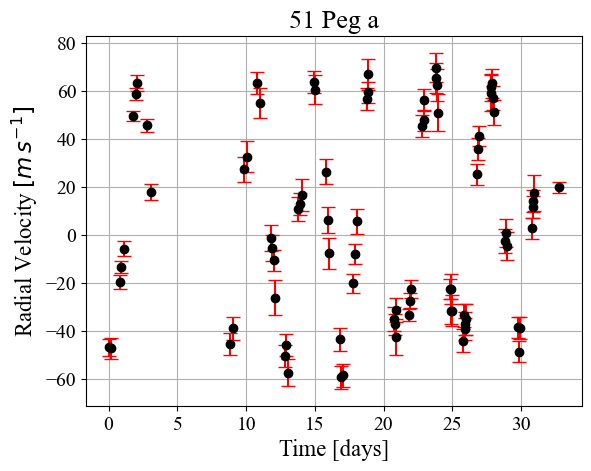

0      0.00000
1      0.15106
2      0.81822
3      0.92392
4      1.09204
        ...   
77    30.79857
78    30.84397
79    30.88947
80    30.92437
81    32.78827
Name: JD, Length: 82, dtype: float64
Initial guesses for P and K are 4.23 and 55.6 respectively


In [23]:
import pandas as pd
from astropy.time import Time

data = pd.read_csv("51Peg_mayorqueloz95.csv")


data['JD']= data['JD'] -  data['JD'][0]



plt.errorbar(data["JD"], data["vrad"], yerr=data["vrad_uncertainty"], fmt='o', color='black', ecolor='red', capsize=5)

plt.xlabel("Time [days]")
plt.ylabel("Radial Velocity $[m \, s^{-1}]$")  
plt.title("51 Peg a")
plt.savefig("pdf/51Peg.pdf")
plt.grid()
plt.show()

print(data["JD"])

# Initial guesses for P and K
P_guess=4.23
K_guess=55.6
print(f'Initial guesses for P and K are {P_guess} and {K_guess} respectively')




In [3]:
def chi_squared(data, data_uncertainty, model):
    return np.sum(((data - model)/ data_uncertainty)**2)


def vrad(t,P, K, f0, v0):
    return K * np.sin(2 * np.pi * (t/P - f0)) + v0

# As instructed in the exercise.

delta_P = 1
P_values = np.arange(P_guess - delta_P, P_guess + delta_P, 0.01)

delta_K = 10
K_values = np.arange(K_guess - delta_K, K_guess + delta_K, 1)


f0_values = np.arange(0, 1, 0.01)

v0_guess = 5
delta_v0 = 10
v0_values = np.arange(v0_guess - delta_v0, v0_guess + delta_v0, 1)


In [4]:
from tqdm import tqdm

# Extract columns from data for convenience
time = data["JD"].values
vrad_obs = data["vrad"].values
vrad_uncertainty = data["vrad_uncertainty"].values

# Array to store minimum chi-squared values for each P
chi2_min_per_P = []

# Loop over values of P to find the one with the minimum chi-squared
for P in tqdm(P_values, desc="Searching Periods (P)", leave=True):
    chi2_min = float('inf')
    for K in K_values:
        for f0 in f0_values:
            for v0 in v0_values:
                # Calculate the model vrad for current parameters
                model = vrad(time, P, K, f0, v0)
                # Calculate chi-squared for this model
                chi2 = chi_squared(vrad_obs, vrad_uncertainty, model)
                # Check if this chi-squared is the lowest found so far for this P
                if chi2 < chi2_min:
                    chi2_min = chi2
    chi2_min_per_P.append(chi2_min)



# Find the period with the minimum chi-squared value
best_P_index = np.argmin(chi2_min_per_P)
best_P = P_values[best_P_index]

# Refine around best_P by searching in a narrower range
fine_P_values = np.arange(best_P - 0.1, best_P + 0.1, 0.001)
fine_chi2_min_per_P = []
best_K, best_f0, best_v0, min_chi2 = None, None, None, float('inf')

# Refined search with progress bar
for P in tqdm(fine_P_values, desc="Refining Best Period", leave=True):
    for K in K_values:
        for f0 in f0_values:
            for v0 in v0_values:
                model = vrad(time, P, K, f0, v0)
                chi2 = chi_squared(vrad_obs, vrad_uncertainty, model)
                
                if chi2 < min_chi2:
                    min_chi2 = chi2
                    best_P, best_K, best_f0, best_v0 = P, K, f0, v0
    fine_chi2_min_per_P.append(min_chi2)


Refining Best Period: 100%|██████████| 200/200 [00:51<00:00,  3.86it/s]


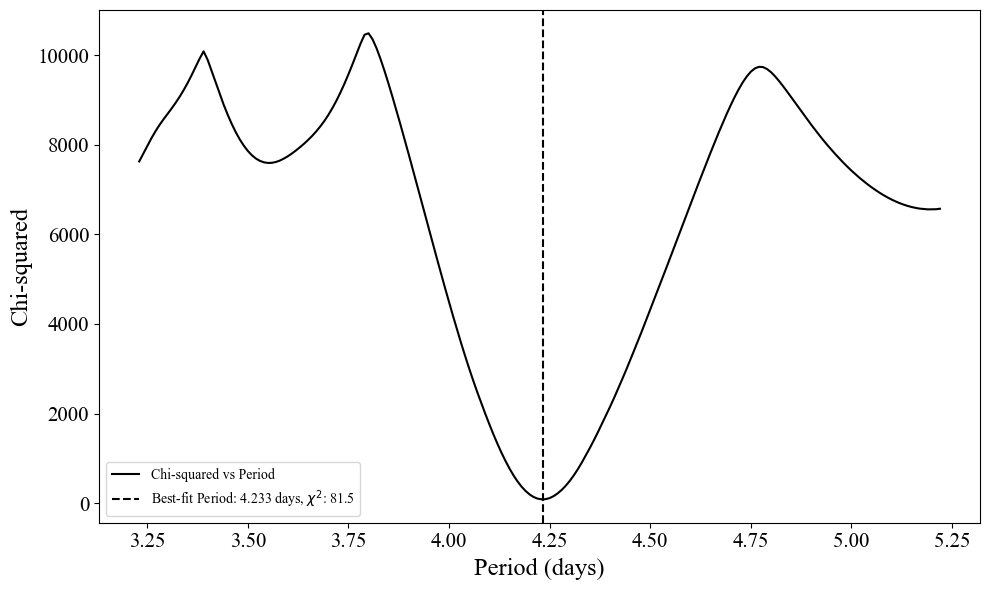

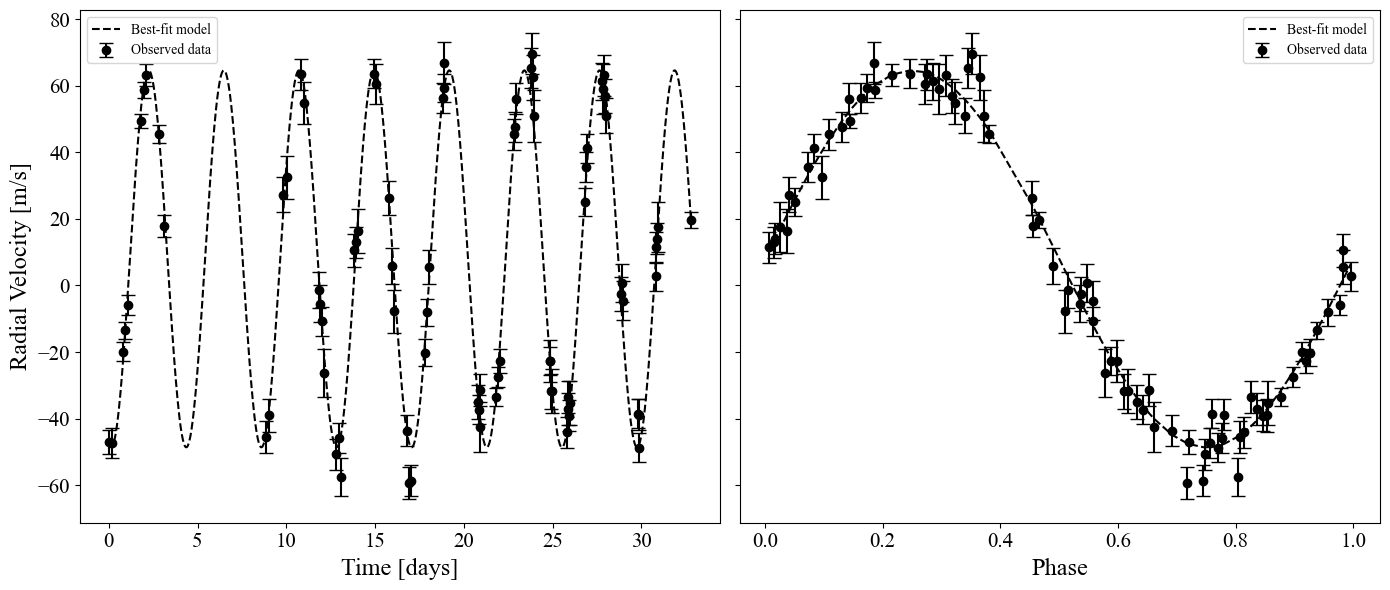

Best-fitting parameters:
Period (P): 4.233000000000014 days
Semi-amplitude (K): 56.6 m/s
Phase offset (f0): 0.28
Systemic velocity (v0): 8 m/s
Minimum Chi-squared: 81.50522781170017


In [33]:

plt.figure(figsize=(10, 6))

# Plot chi-squared as a function of P
plt.plot(P_values, chi2_min_per_P, label="Chi-squared vs Period", c='black')
plt.axvline(best_P, color='red', linestyle='--', label=f"Best-fit Period: {best_P:.3f} days, $\chi^2$: {min_chi2:.1f}", c='black')
plt.xlabel("Period (days)")
plt.ylabel("Chi-squared")
plt.legend()
plt.tight_layout()
plt.savefig("pdf/chi2.pdf")
plt.show()


# Final plot: observed vs model
phases = (time / best_P - best_f0) % 1  # Phase folding
best_model = vrad(time, best_P, best_K, best_f0, best_v0)

# Sort phases and corresponding radial velocities
sorted_indices = np.argsort(phases)
sorted_phases = phases[sorted_indices]
sorted_vrad_obs = vrad_obs[sorted_indices]
sorted_best_model = best_model[sorted_indices]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot observed vs model over time
times = np.linspace(time[0], time[-1], 1000)
best_model = vrad(times, best_P, best_K, best_f0, best_v0)
ax1.errorbar(time, vrad_obs, yerr=vrad_uncertainty, label="Observed data", fmt='o', color='black', ecolor='black', capsize=5)
ax1.plot(times, best_model, label="Best-fit model", color="black", linestyle='--')
ax1.set_ylabel("Radial Velocity [m/s]")
ax1.set_xlabel(r"Time [days]")
ax1.legend()

# Plot observed vs model
ax2.errorbar(sorted_phases, sorted_vrad_obs, yerr=vrad_uncertainty[sorted_indices], label="Observed data", fmt='o', color='black', ecolor='black', capsize=5)
ax2.plot(sorted_phases, sorted_best_model, label="Best-fit model", color="black", linestyle='--')
ax2.set_xlabel("Phase")
ax2.legend()

plt.tight_layout()
plt.savefig("pdf/model_fit.pdf")
plt.show()

# Print best-fitting parameters
print("Best-fitting parameters:")
print(f"Period (P): {best_P} days")
print(f"Semi-amplitude (K): {best_K} m/s")
print(f"Phase offset (f0): {best_f0}")
print(f"Systemic velocity (v0): {best_v0} m/s")
print(f"Minimum Chi-squared: {min_chi2}")




In [6]:
from astropy.constants import G, M_sun, M_jup

def calculate_Mp(M_star, P, i, K, P_error=None, K_error=None):
    """
    Calculate the mass of the planet (M_P) in Jupiter masses using the provided parameters.
    
    Parameters:
    M_star (float): Mass of the star in solar masses (M_sun)
    P (float): Orbital period in days
    i (float): Orbital inclination in degrees
    K (float): Constant (default is 1.0, adjust based on your system)
    
    Returns:
    float: Mass of the planet (M_P) in Jupiter masses
    """
    
    # Convert inclination angle to radians
    i_radians = np.radians(i)
    
    # Gravitational constant G from astropy, in units of m^3 kg^-1 s^-2
    G_value = G.value  # Extract the value of G in SI units (m^3 kg^-1 s^-2)
    M_P = K * M_star**(2/3) * ((P / (2 * np.pi * G_value))**(1/3)) / np.sin(i_radians)
    # Calculate M_P in Jupiter masses (M_J)
    if not P_error and not K_error:
        return M_P
     
    else:    # Calculate the error in M_P
        K_error_part =K_error* M_star**(2/3) * ((P / (2 * np.pi * G_value))**(1/3)) / np.sin(i_radians) 
        P_error_part = K * M_star**(2/3) * (P**(-2/3)) / (2 * np.pi * G_value)**(1/3) / (3*np.sin(i_radians)) * P_error
        M_P_error = np.sqrt(P_error_part**2 + K_error_part**2) 
        return M_P, M_P_error

minimal_planet_mass = calculate_Mp(1.06 * M_sun.value, best_P *24*3600, 90, best_K) / M_jup.value
print(minimal_planet_mass)




0.46833689335525774


In [7]:
len(vrad_obs)


82

In [8]:
from  scipy.stats import chi2

dof = len(time) - 4
print(f'DoF: {dof}')


chi2_lim = chi2.ppf(0.95, dof)
print(f' chi2: {min_chi2} , chi2_lim: {chi2_lim}')


DoF: 78
 chi2: 81.50522781170017 , chi2_lim: 99.61692732428385


In [9]:
# create pandadataframe with the best fitting parameters
df  =  pd.DataFrame({'Period (P)': [best_P], 'Semi-amplitude (K)': [best_K], 'Phase offset (f0)': [best_f0], 'Systemic velocity (v0)': [best_v0], 'Minimum Chi-squared': [min_chi2]})
df['planet_mass (M_{odot})'] = minimal_planet_mass
df['DoF'] = dof
df['chi2_lim'] = chi2_lim
df.to_csv("csv/best_fitting_parameters.csv", index=False)

In [10]:
import emcee

def lnL(theta, x, y, yerr):
    """
    The log likelihood of model.
    """
    P, K, f0, v0 = theta
    model = vrad(x,P, K, f0, v0)
    chi2 = chi_squared(vrad_obs, vrad_uncertainty, model)
    return -0.5 * chi2

def lnprior(theta):
    P, K, f0, v0 = theta
    if 4 < P < 4.5 and 50 < K < 60 and 0.23 < f0 < 0.33 and 5 < v0 < 15:
        return 0.0
    return -np.inf

def lnpriorgaussian(theta):
    P, K, f0, v0 = theta
    P_prior = -0.5 * ((P - best_P) / 0.2)**2
    K_prior = -0.5 * ((K - best_K) / 10.0)**2
    f0_prior = -0.5 * ((f0 - best_f0) / 0.1)**2
    v0_prior = -0.5 * ((v0 - best_v0) / 10.0)**2
    return P_prior + K_prior + f0_prior + v0_prior

def lnprobgaussian(theta, x, y, yerr):
    lp = lnpriorgaussian(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(theta, x, y, yerr)

def lnprob(theta, x, y, yerr):
    """
    The likelihood to include in the MCMC.
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(theta, x, y, yerr)




(100, 500, 4)


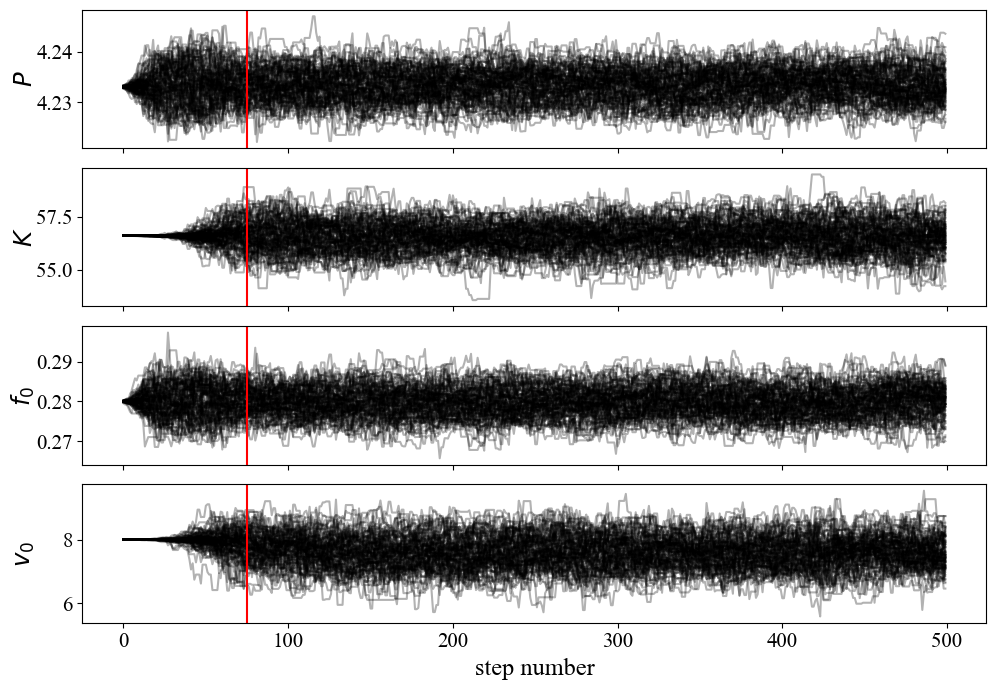

(42500, 4)


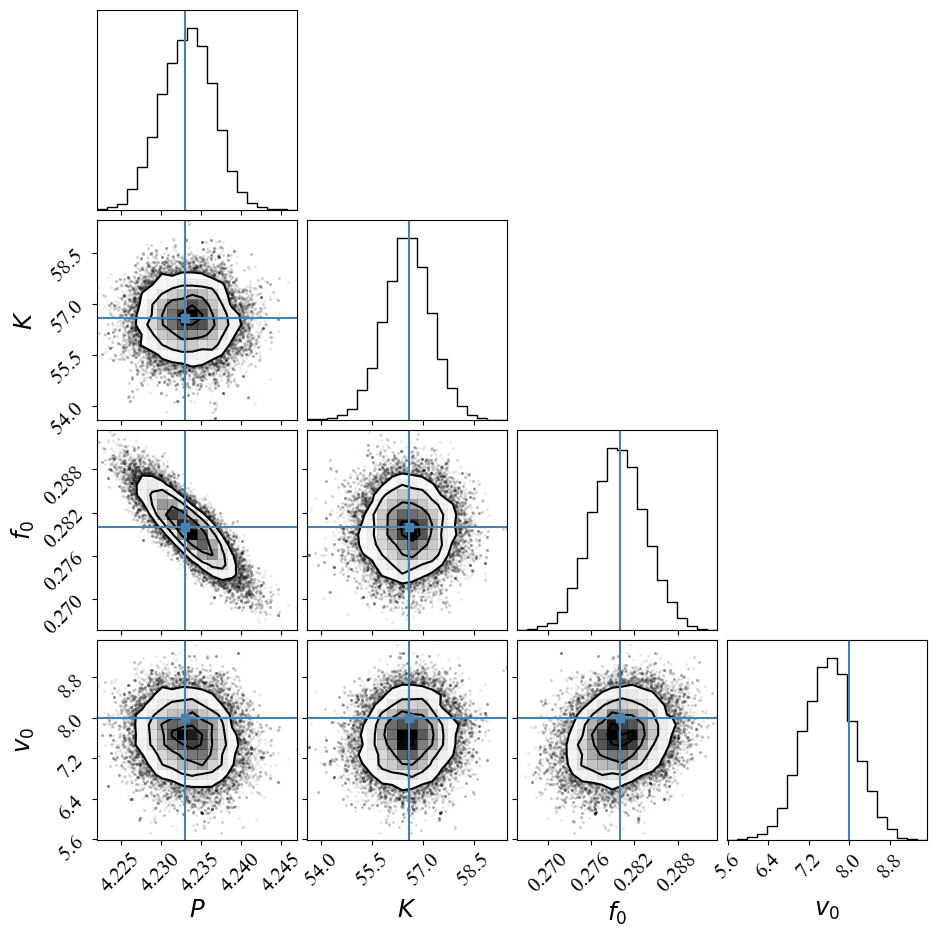

In [34]:

ndim, nwalkers = 4, 100
pos = [np.array([best_P, best_K, best_f0, best_v0]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time, vrad_obs, vrad_uncertainty))

tmp = sampler.run_mcmc(pos, 500)

print(sampler.chain.shape)

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

labels = ["$P$", "$K$", "$f_0$", "$v_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].transpose(), color="black", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.axvline(75, color='red')
    ax.yaxis.set_label_coords(-0.05, 0.5)

ax.set_xlabel("step number")
#axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.savefig("pdf/emcee.pdf")
plt.show()

    
samples = sampler.chain[:, 75:, :].reshape((-1, ndim))
print(samples.shape)

import corner



fig = corner.corner(samples, labels=labels, truths=[best_P, best_K, best_f0, best_v0])


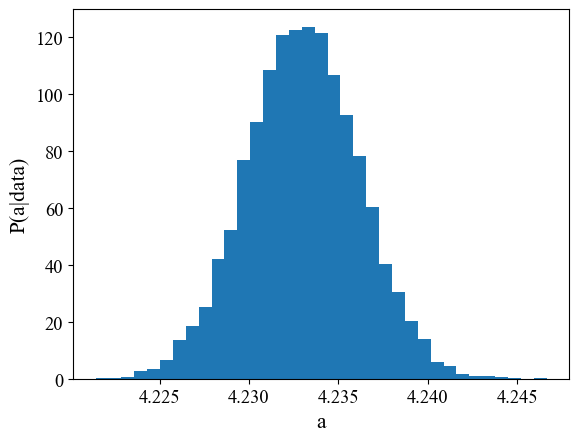

[4.22989835 4.23299934 4.23614716]
P(a|data) = 4.232999338098592 + 0.0031478175045531742 - 0.00310098552774285


In [12]:
import scipy.stats as st
h  = plt.hist(samples[:,0], bins=35, density=True)
plt.xlabel("a")
plt.ylabel("P(a|data)")
plt.show()

summary_a = st.scoreatpercentile(samples[:, 0], [16, 50, 84])
print(summary_a)

print(f'P(a|data) = {summary_a[1]} + {summary_a[2]-summary_a[1]} - {summary_a[1]-summary_a[0]}')


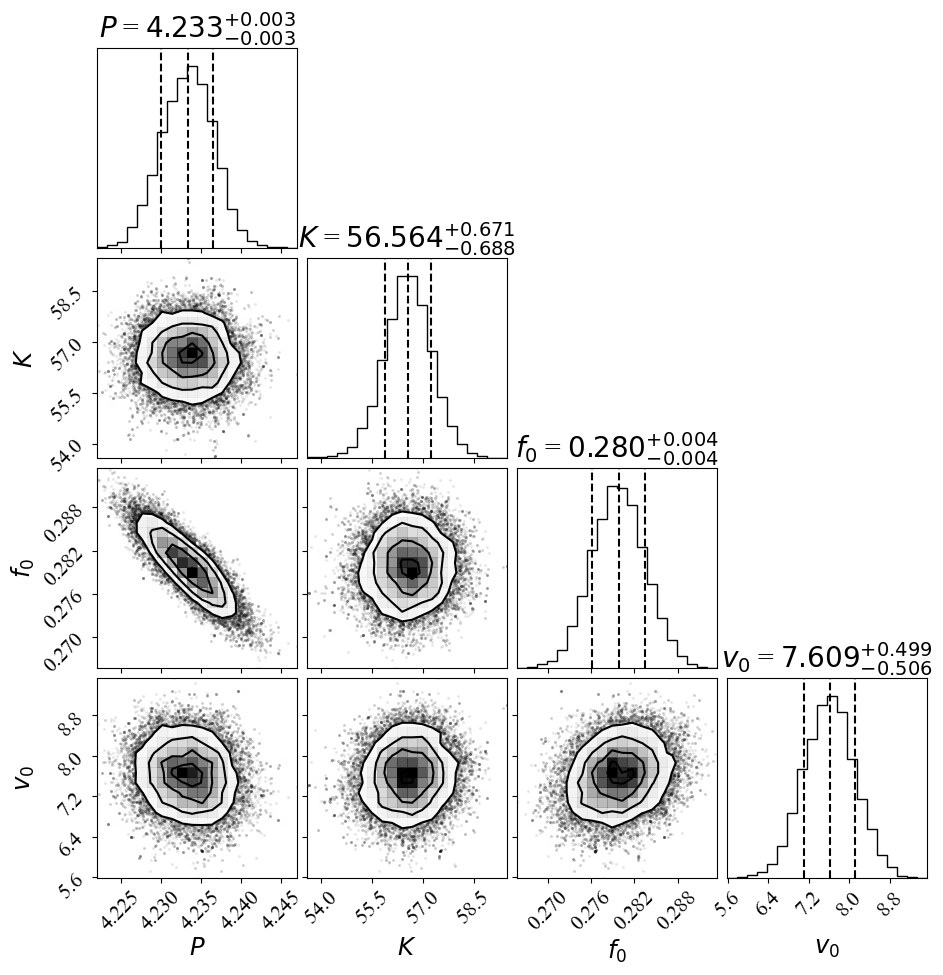

In [35]:
# Format the truths with different precision
truths = [
    f"{best_P:.3f}",  # 3 digits for P
    f"{best_K:.2f}",  # 2 digits for K
    f"{best_f0:.3f}",  # 3 digits for f0
    f"{best_v0:.2f}"   # 2 digits for v0
]
fig = corner.corner(
    samples,
    labels=labels,
    truths=truths,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".3f"
)
plt.savefig("pdf/corner.pdf")

In [27]:
median_P = np . percentile ( samples [: , 0] , 50.0)
p16_P = np . percentile ( samples [: , 0] , 16)
p84_P = np . percentile ( samples [: , 0] , 84)
sigma_P = 0.5 * ( p84_P - p16_P)
print('Values for P', median_P, sigma_P)

median_K = np . percentile ( samples [: , 1] , 50.0)
p16_K = np . percentile ( samples [: , 1] , 16)
p84_K = np . percentile ( samples [: , 1] , 84)
sigma_K = 0.5 * ( p84_K - p16_K)
print('Values for K',median_K, sigma_K)


minimal_planet_mass = calculate_Mp(1.06 * M_sun.value, median_P *24*3600, 90, median_K, P_error= sigma_P, K_error=sigma_K) / M_jup.value
print('The planets minimal mass is',minimal_planet_mass[0], '+-', minimal_planet_mass[1])



Values for P 4.233364215671274 0.003145539913989026
Values for K 56.5735661619089 0.6699320733748095
The planets minimal mass is 0.46813159202348775 +- 0.005543514212256135


In [28]:
# Try to find the differencees using scipy.curvefit
from scipy.optimize import curve_fit

popt, pcov = curve_fit(vrad, time, vrad_obs, sigma=vrad_uncertainty, p0=[best_P, best_K, best_f0, best_v0])
print(popt, np.sqrt(np.diag(pcov)))

[ 4.23324283 56.5440683   0.27990981  7.60488751] [0.00317193 0.70632068 0.00365239 0.50865387]


(200, 500, 4)


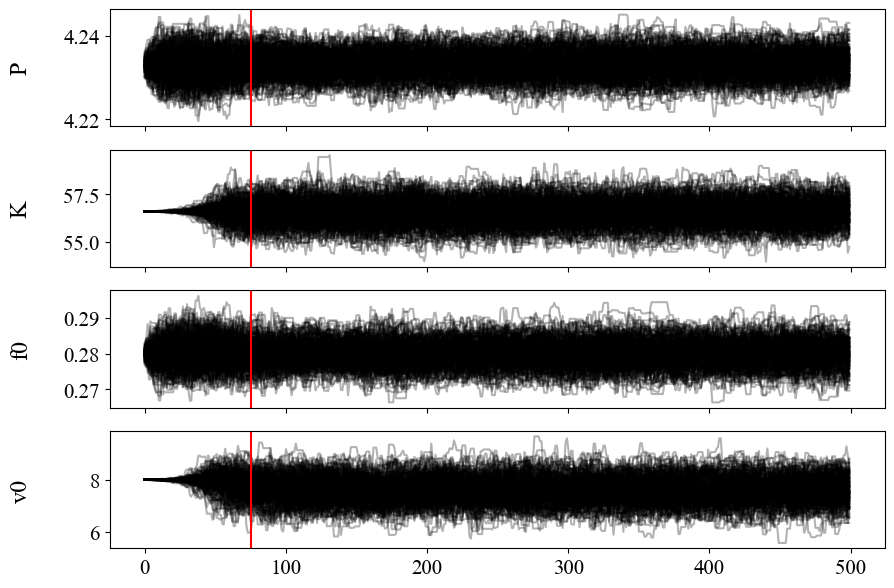

(85000, 4)
Values for P 4.233254564522751 0.0031546687127139705
Values for K 56.51776363078122 0.6750436395373676
The planets minimal mass is 0.47644857874820934 +- 0.005690663642526738


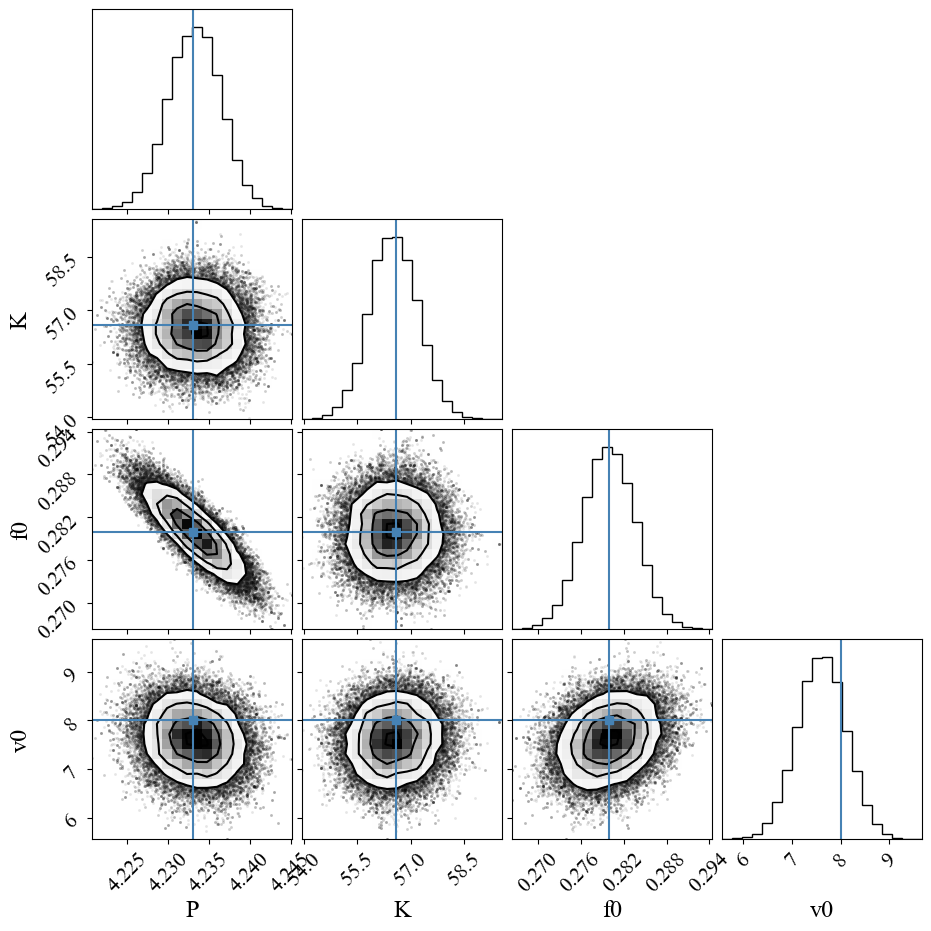

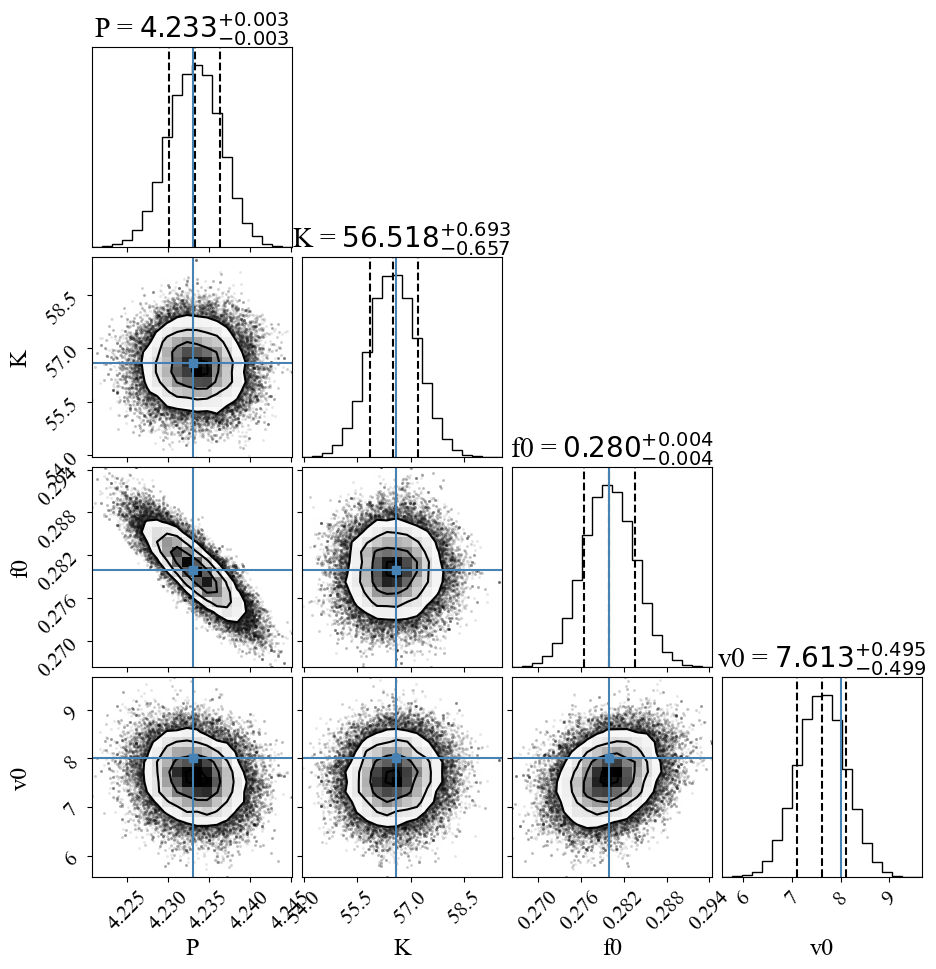

In [36]:

ndim, nwalkers = 4, 200
pos = [np.array([best_P, best_K, best_f0, best_v0]) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobgaussian, args=(time, vrad_obs, vrad_uncertainty))

tmp = sampler.run_mcmc(pos, 500)

print(sampler.chain.shape)

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

labels = ["P", "K", "f0", "v0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].transpose(), color="black", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.axvline(75, color='red')
    ax.yaxis.set_label_coords(-0.1, 0.5)

#axes[-1].set_xlabel("step number")
#plt.savefig("pdf/emcee.pdf")
plt.show()

    
samples = sampler.chain[:, 75:, :].reshape((-1, ndim))
print(samples.shape)

import corner



fig = corner.corner(samples, labels=labels, truths=[best_P, best_K, best_f0, best_v0])

fig = corner.corner(
    samples,
    labels=labels,
    truths=[best_P, best_K, best_f0, best_v0],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".3f"
    
)

median_P = np . percentile ( samples [: , 0] , 50.0)
p16_P = np . percentile ( samples [: , 0] , 16)
p84_P = np . percentile ( samples [: , 0] , 84)
sigma_P = 0.5 * ( p84_P - p16_P)
print('Values for P', median_P, sigma_P)

median_K = np . percentile ( samples [: , 1] , 50.0)
p16_K = np . percentile ( samples [: , 1] , 16)
p84_K = np . percentile ( samples [: , 1] , 84)
sigma_K = 0.5 * ( p84_K - p16_K)
print('Values for K',median_K, sigma_K)


minimal_planet_mass = calculate_Mp(1.09 * M_sun.value, median_P *24*3600, 90, median_K, P_error= sigma_P, K_error=sigma_K) / M_jup.value
print('The planets minimal mass is',minimal_planet_mass[0], '+-', minimal_planet_mass[1])

In [37]:
def planetOrbitRadius(P, M):
    """
    Calculate the semi-major axis of the planet's orbit given the period and mass of the star.
    """
    # Convert period to seconds
    P_seconds = P * 24 * 3600
    # Convert mass of the star to kg
    M_kg = M * M_sun.value
    # Calculate the semi-major axis using Kepler's third law
    a = (G.value * M_kg * P_seconds**2 / (4 * np.pi**2))**(1/3)
    return a

def planetOrbitRadiusError(P, M, P_err, M_err):
    """
    Calculate the error in the semi-major axis of the planet's orbit using error propagation.
    """
    # Convert period to seconds
    P_seconds = P * 24 * 3600
    # Convert mass of the star to kg
    M_kg = M * M_sun.value
    
    # Calculate the semi-major axis using Kepler's third law
    a = planetOrbitRadius(P, M)

    # Partial derivatives
    d_a_d_P = (2 / 3) * P_seconds**(-1 / 3) * (G.value * M_kg / (4 * np.pi**2))**(1 / 3)
    d_a_d_M = (1 / 3) * P_seconds**(2 / 3) * (G.value / (4 * np.pi**2))**(1 / 3) * M_kg**(-2 / 3)

    # Error propagation
    delta_a = np.sqrt((d_a_d_P * P_err * 24 * 3600 / a)**2 + (d_a_d_M * M_err * M_sun.value / a)**2)
    
    return delta_a

# Given values
median_P = 4.233  # Orbital period in days
P_err = 0.003  # Error in period in days
M_star = 1.09  # Star mass in solar masses
M_star_err = 0.02  # Error in star mass in solar masses

# Calculate orbital radius and its error
orbital_radius = planetOrbitRadius(median_P, M_star) / 1.496e11  # Convert from meters to AU
orbital_radius_error = planetOrbitRadiusError(median_P, M_star, P_err, M_star_err) / 1.496e11  # Convert from meters to AU

print(f"The planet's orbital radius is {orbital_radius:.5f} AU ± {orbital_radius_error:.5f} AU")

The planet's orbital radius is 0.05270 AU ± 0.00000 AU


In [38]:
import numpy as np

def calculate_mass(K, P, M_star, i):
    """
    Calculate the mass of the planet M_P in units of Jupiter mass (M_Jup).
    
    Parameters:
        K (float): Velocity amplitude in km/s.
        P (float): Orbital period in days.
        M_star (float): Mass of the star in solar masses (M_sun).
        i (float): Orbital inclination in degrees.
    
    Returns:
        M_P (float): Planet mass in Jupiter masses (M_Jup).
    """
    # Convert inclination to radians
    i_rad = np.radians(i)
    
    # Calculate mass using the formula
    M_P = (K / 203.255) * (P / 1)**(1/3) * (M_star)**(2/3) / np.sin(i_rad)
    
    return M_P

# Example usage
K = 56.6  # km/s
P = 4.233  # days
M_star = 1.09  # M_sun
i = 90.0  # degrees



def propagate_uncertainty(K, P, M_star, i, sigma_K, sigma_P, sigma_M_star):
    """
    Propagate uncertainties for K, P, and M_star to get the uncertainty in the mass M_P.
    
    Parameters:
        K (float): Velocity amplitude in km/s.
        P (float): Orbital period in days.
        M_star (float): Mass of the star in solar masses (M_sun).
        i (float): Orbital inclination in degrees.
        sigma_K (float): Uncertainty in K (km/s).
        sigma_P (float): Uncertainty in P (days).
        sigma_M_star (float): Uncertainty in M_star (M_sun).
    
    Returns:
        sigma_M_P (float): Propagated uncertainty in the planet mass (M_Jup).
    """
    # First, calculate the planet mass
    M_P = calculate_mass(K, P, M_star, i)
    
    # Derivative with respect to K
    dM_P_dK = (1 / 203.255) * (P / 1)**(1/3) * (M_star)**(2/3) / np.sin(np.radians(i))
    
    # Derivative with respect to P
    dM_P_dP = M_P * (1 / (3 * P))
    
    # Derivative with respect to M_star
    dM_P_dM_star = (2 / 3) * (M_star**(-1/3)) * (K / 203.255) * (P / 1)**(1/3) / np.sin(np.radians(i))
    
    # Propagate the uncertainty
    sigma_M_P = np.sqrt((dM_P_dK * sigma_K)**2 + (dM_P_dP * sigma_P)**2 + (dM_P_dM_star * sigma_M_star)**2)
    
    return sigma_M_P


sigma_K = 0.7  # Uncertainty in K (km/s)
sigma_P = 0.004  # Uncertainty in P (days)
sigma_M_star = 0.02  # Uncertainty in M_star (M_sun)

mass = calculate_mass(K, P, M_star, i)
uncertainty = propagate_uncertainty(K, P, M_star, i, sigma_K, sigma_P, sigma_M_star)

print(f"Planet mass: {mass:.3f} M_Jup ± {uncertainty:.3f} M_Jup")


Planet mass: 0.477 M_Jup ± 0.008 M_Jup
